# Data Set Information:

https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume#

Hourly Interstate 94 Westbound traffic volume for MN DoT ATR station 301, roughly midway between Minneapolis and St Paul, MN. Hourly weather features and holidays included for impacts on traffic volume.

In [190]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [96]:
df = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")
df.head(5)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


# 1. EDA

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [98]:
df.shape

(48204, 9)

In [99]:
df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


**Удалим неинтересующие нас столбцы**

In [100]:
df.columns

Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'date_time', 'traffic_volume'],
      dtype='object')

In [101]:
df = df.drop(columns=['rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description'], axis=1)
df.head(2)

,holiday,temp,date_time,traffic_volume
0,None,288.28,2012-10-02 09:00:00,5545
1,None,289.36,2012-10-02 10:00:00,4516


In [102]:
df['holiday'].unique()

array(['None', 'Columbus Day', 'Veterans Day', 'Thanksgiving Day',
       'Christmas Day', 'New Years Day', 'Washingtons Birthday',
       'Memorial Day', 'Independence Day', 'State Fair', 'Labor Day',
       'Martin Luther King Jr Day'], dtype=object)

In [103]:
df['temp'].unique()

array([288.28, 289.36, 289.58, ..., 306.08, 304.41, 304.9 ])

**Конверитируем колонку date_time в datetime и устанавливаем её как индекс**

In [104]:
df['date_time'] =  pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M:%S')

In [105]:
df = df.set_index(pd.DatetimeIndex(df['date_time']))

**Проверим дубликаты**

In [106]:
df.duplicated().sum()

7551

In [107]:
df = df.drop_duplicates()

In [108]:
df.duplicated().sum()

0

In [109]:
df.shape

(40653, 4)

**Взглянем на пропущенные значения**

In [110]:
df.isna().sum()

holiday           0
temp              0
date_time         0
traffic_volume    0
dtype: int64

**Временной промежуток в датасете**

In [111]:
len(df['date_time'].unique())

40575

А вот реальный промежуток...

In [112]:
pd.date_range(start='2012-10-02 09:00:00', end='2018-09-30 23:00:00', freq='H')

DatetimeIndex(['2012-10-02 09:00:00', '2012-10-02 10:00:00',
               '2012-10-02 11:00:00', '2012-10-02 12:00:00',
               '2012-10-02 13:00:00', '2012-10-02 14:00:00',
               '2012-10-02 15:00:00', '2012-10-02 16:00:00',
               '2012-10-02 17:00:00', '2012-10-02 18:00:00',
               ...
               '2018-09-30 14:00:00', '2018-09-30 15:00:00',
               '2018-09-30 16:00:00', '2018-09-30 17:00:00',
               '2018-09-30 18:00:00', '2018-09-30 19:00:00',
               '2018-09-30 20:00:00', '2018-09-30 21:00:00',
               '2018-09-30 22:00:00', '2018-09-30 23:00:00'],
              dtype='datetime64[ns]', length=52551, freq='H')

Видим пропуски. Реальная временная метка, **length=52551**

Поработаем над пропусками

In [113]:
# Создадим  DataFrame без пропусков во времени
data = pd.DataFrame({'real_date_time': pd.date_range(start='2012-10-02 09:00:00', end='2018-09-30 23:00:00', freq='H')})

In [114]:
# Приведём к формату datetime
data['date_time'] =  pd.to_datetime(data['real_date_time'], format='%Y-%m-%d %H:%M:%S')

In [115]:
# Сделаем индексы
data = data.set_index(pd.DatetimeIndex(data['date_time']))

In [116]:
data.head(2)

,real_date_time,date_time
date_time,,
2012-10-02 09:00:00,2012-10-02 09:00:00,2012-10-02 09:00:00
2012-10-02 10:00:00,2012-10-02 10:00:00,2012-10-02 10:00:00


In [117]:
data = data.drop(columns=['date_time'], axis=1)

In [118]:
data.head(2)

,real_date_time
date_time,
2012-10-02 09:00:00,2012-10-02 09:00:00
2012-10-02 10:00:00,2012-10-02 10:00:00


In [119]:
len(data)

52551

In [120]:
len(df)

40653

In [121]:
df.head(2)

,holiday,temp,date_time,traffic_volume
date_time,,,,
2012-10-02 09:00:00,None,288.28,2012-10-02 09:00:00,5545
2012-10-02 10:00:00,None,289.36,2012-10-02 10:00:00,4516


In [122]:
df_new = data.merge(df, how='left', left_on='real_date_time', right_index=True)

In [123]:
df_new = df_new.set_index('date_time')

In [124]:
len(df_new)

52629

In [125]:
df_new.head(3)

,real_date_time,holiday,temp,traffic_volume
date_time,,,,
2012-10-02 09:00:00,2012-10-02 09:00:00,None,288.28,5545.0
2012-10-02 10:00:00,2012-10-02 10:00:00,None,289.36,4516.0
2012-10-02 11:00:00,2012-10-02 11:00:00,None,289.58,4767.0


In [126]:
df_new = df_new.drop(columns=['real_date_time'], axis=1)

In [127]:
df = df_new.interpolate(method='linear')
df.head(3)

,holiday,temp,traffic_volume
date_time,,,
2012-10-02 09:00:00,None,288.28,5545.0
2012-10-02 10:00:00,None,289.36,4516.0
2012-10-02 11:00:00,None,289.58,4767.0


**Попробуем взять только данные с июня 2018 по 30 сентября 2018**

In [128]:
df = df['2018-06-01':'2018-09-30']
df.head()

,holiday,temp,traffic_volume
date_time,,,
2018-06-01 00:00:00,None,294.28,786.0
2018-06-01 01:00:00,None,293.22,497.0
2018-06-01 02:00:00,None,292.22,346.0
2018-06-01 03:00:00,None,291.43,395.0
2018-06-01 04:00:00,None,291.15,872.0


In [129]:
df.shape

(2923, 3)

**Отложим последние две недели из датасета для тестов**

In [130]:
split_date = '2018-09-16'
df_train = df.iloc[df.index < split_date].copy()
df_test = df.iloc[df.index > split_date].copy()

In [131]:
(df_train.shape, df_test.shape)

((2563, 3), (359, 3))

In [132]:
def plot_data(df):
  """ Отрисовка временного ряда """
  plt.figure(figsize=(18,8))
  plt.plot(df_train.traffic_volume)
  plt.plot(df_test.traffic_volume)
  plt.show()

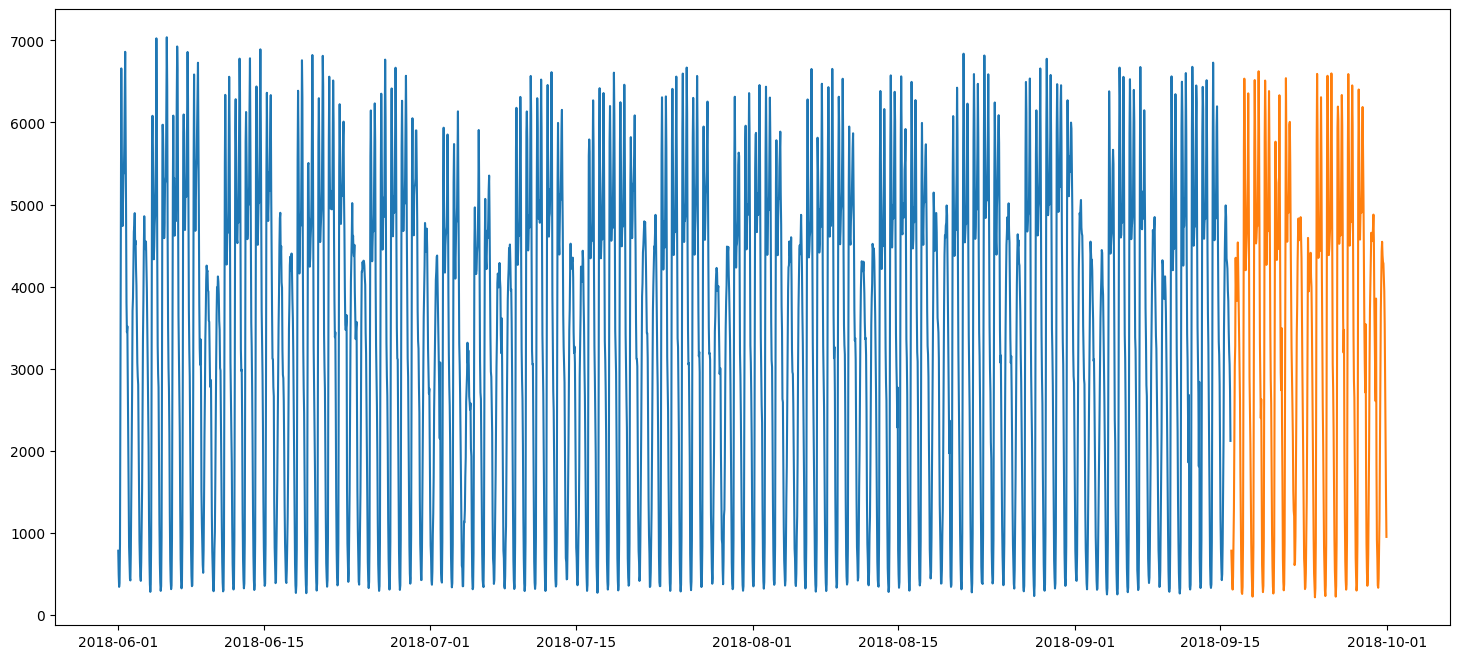

In [133]:
plot_data(df)

# Генерируем дополнительные признаки

In [134]:
def create_features(df, label=None):
    """
    Генерируем дополнительные признаки из datetime
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['day_of_week'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['day_of_year'] = df['date'].dt.dayofyear
    df['day_of_month'] = df['date'].dt.day
    df['week_of_year'] = df['date'].dt.weekofyear
    
    X = df[['hour','day_of_week','quarter','month','year','day_of_year','day_of_month','week_of_year']]
    
    if label:
        y = df[label]
        return X, y
    return X

**Метрики**

In [135]:
def mean_absolute_percentage_error(y_true, y_pred): 

  """ MAPE """
  
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [136]:
def error_metrics(y_true, y_pred):

  """ Подсчёт метрик и вывод на экран """
  
  print('Mean Absolute Error: {:.2f}'.format(mean_absolute_error(y_true, y_pred)))
  print('Root Mean Squared Error: {:.2f}'.format(np.sqrt(mean_squared_error(y_true, y_pred))))
  print('Mean Absolute Percentage Error: {:.2f} %'.format(mean_absolute_percentage_error(y_true, y_pred)))

# Baseline

In [137]:
new_features_train = create_features(df_train)

In [138]:
df_groupby_train = df_train.groupby(["day_of_week", "hour"])["traffic_volume"].mean()

In [139]:
new_features_test = create_features(df_test)

In [140]:
df_groupby_test = df_test.groupby(["day_of_week", "hour"])["traffic_volume"].mean()

Интересно, какие метрики покажет Baseline

In [141]:
error_metrics(df_groupby_train, df_groupby_test)

Mean Absolute Error: 169.94
Root Mean Squared Error: 230.06
Mean Absolute Percentage Error: 7.27 %


**Деление на train и test**

In [142]:
X_train, y_train = create_features(df_train, label='traffic_volume')
X_test, y_test = create_features(df_test, label='traffic_volume')

In [143]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2563, 8), (359, 8), (2563,), (359,))

# LinearRegression

In [144]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [145]:
%%time
y_pred = lr.predict(X_test)

CPU times: user 2.17 ms, sys: 123 µs, total: 2.3 ms
Wall time: 3.94 ms


In [146]:
def plot_predictions(y_pred):
  """ Отрисока предсказаний """
  plt.figure(figsize=(15,6))
  plt.plot(df_test.index, pd.DataFrame(df_test.traffic_volume), marker='.', label="actual")
  plt.plot(df_test.index, y_pred, 'r', label="prediction")
  plt.ylabel('Traffic Volume', size=15)
  plt.xlabel('Date', size=15)
  plt.legend(fontsize=13)
  plt.show()

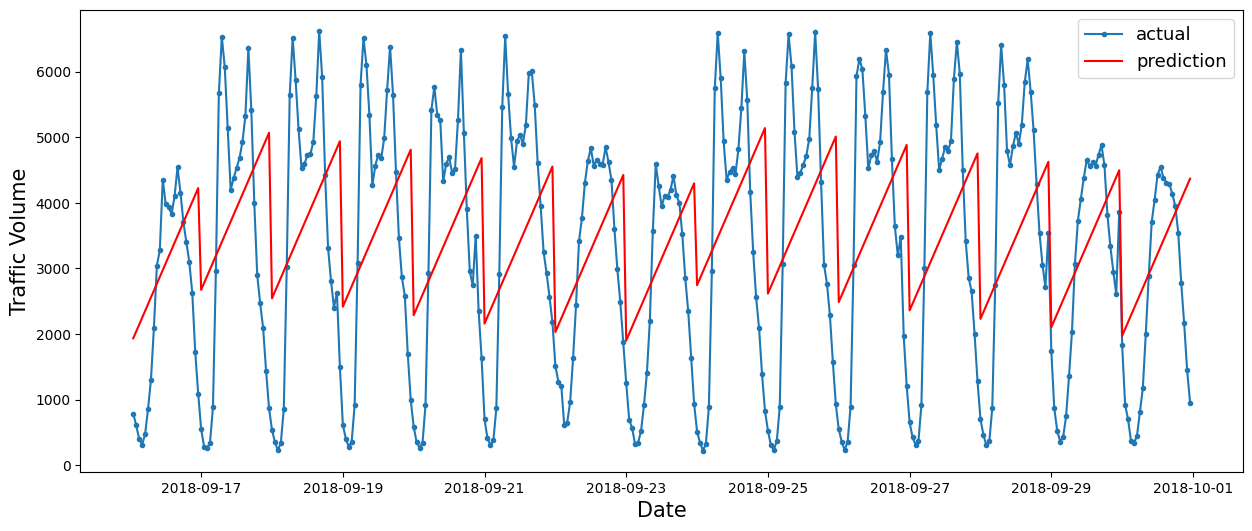

In [147]:
plot_predictions(y_pred)

In [148]:
error_metrics(df_test['traffic_volume'], y_pred)

Mean Absolute Error: 1568.33
Root Mean Squared Error: 1802.91
Mean Absolute Percentage Error: 141.51 %


In [149]:
def plotCoefficients(model, X_train):
    """
    Plots sorted coefficient values of the model
    """
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(8, 5))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

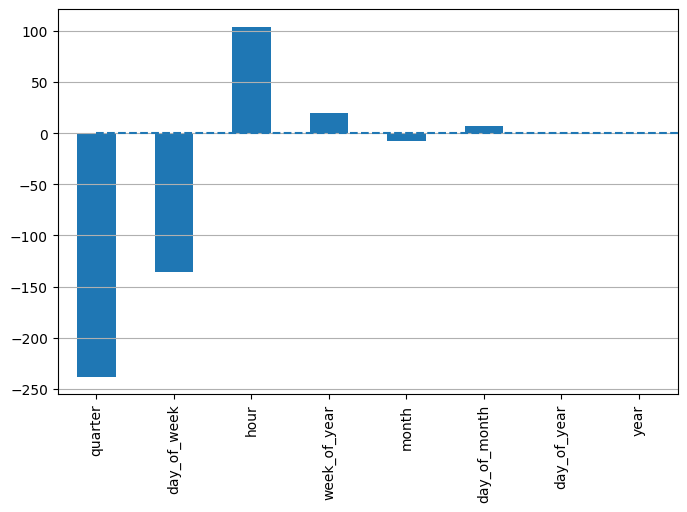

In [150]:
plotCoefficients(lr, X_train)

# RandomForestClassifier

In [151]:
%%time
rf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
rf.fit(X_train, y_train)

CPU times: user 274 ms, sys: 3.75 ms, total: 277 ms
Wall time: 279 ms


RandomForestClassifier(max_depth=3, random_state=42)

In [152]:
%%time
y_pred = rf.predict(X_test)

CPU times: user 202 ms, sys: 283 µs, total: 202 ms
Wall time: 200 ms


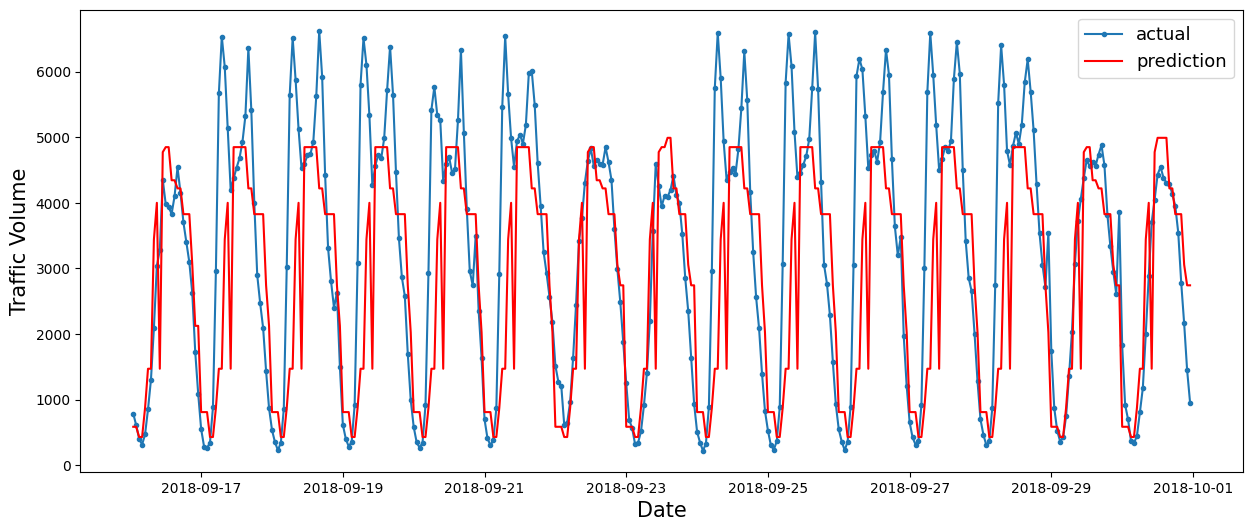

In [153]:
plot_predictions(y_pred)

In [154]:
error_metrics(df_test['traffic_volume'], y_pred)

Mean Absolute Error: 1005.28
Root Mean Squared Error: 1526.81
Mean Absolute Percentage Error: 40.44 %


# GradientBoostingRegressor

In [155]:
%time
gb = GradientBoostingRegressor(n_estimators=100)
gb.fit(X_train, y_train)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 8.34 µs


GradientBoostingRegressor()

In [156]:
%%time
y_pred = gb.predict(X_test)

CPU times: user 2.42 ms, sys: 302 µs, total: 2.72 ms
Wall time: 2.74 ms


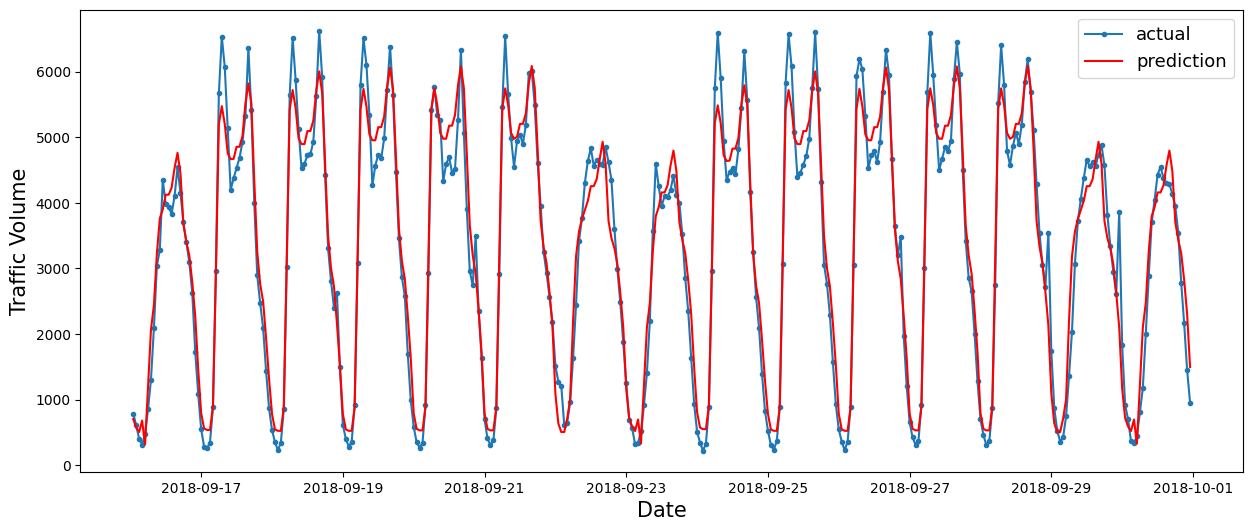

In [157]:
plot_predictions(y_pred)

In [158]:
error_metrics(df_test['traffic_volume'], y_pred)

Mean Absolute Error: 312.54
Root Mean Squared Error: 395.68
Mean Absolute Percentage Error: 18.56 %


# XGBRegressor

In [159]:
%%time
reg = xgb.XGBRegressor(n_estimators=100)
reg.fit(X_train, y_train)

CPU times: user 317 ms, sys: 9.69 ms, total: 327 ms
Wall time: 200 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [160]:
%%time
y_pred = reg.predict(X_test)

CPU times: user 4.04 ms, sys: 0 ns, total: 4.04 ms
Wall time: 5.32 ms


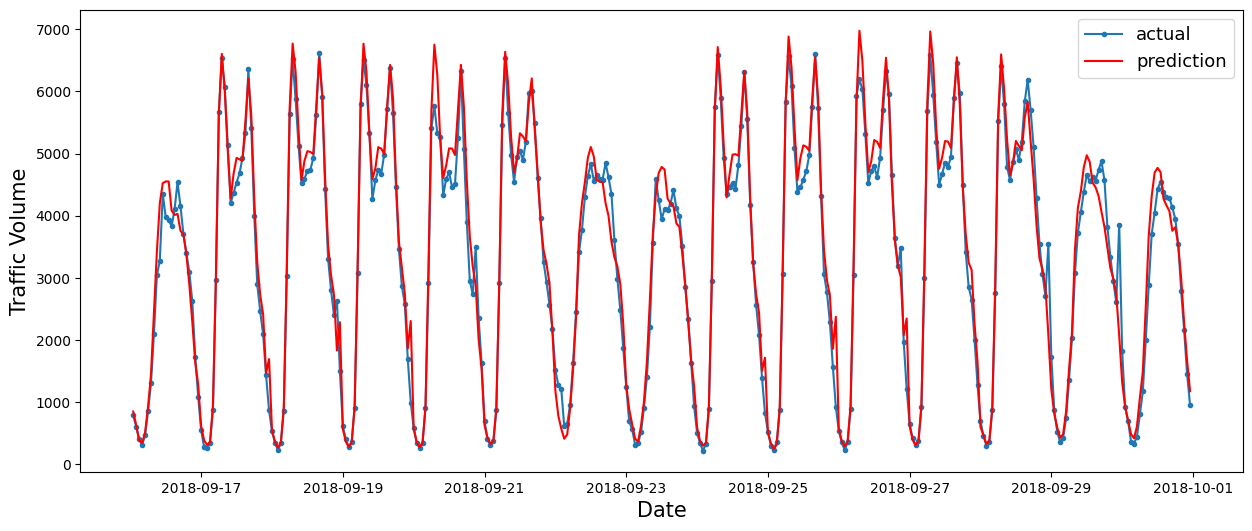

In [161]:
plot_predictions(y_pred)

In [162]:
error_metrics(df_test['traffic_volume'], y_pred)

Mean Absolute Error: 236.67
Root Mean Squared Error: 343.56
Mean Absolute Percentage Error: 10.03 %


# Prophet

In [163]:
# !pip install prophet

In [164]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

df_fbp = pd.DataFrame()
df_fbp["ds"] = pd.to_datetime(df.index)
df_fbp["y"] = df['traffic_volume'].values

In [165]:
df_fbp.head()

,ds,y
0,2018-06-01 00:00:00,786.0
1,2018-06-01 01:00:00,497.0
2,2018-06-01 02:00:00,346.0
3,2018-06-01 03:00:00,395.0
4,2018-06-01 04:00:00,872.0


In [166]:
fb_y_train = df_fbp.iloc[:-359].copy()
fb_y_test = df_fbp.iloc[-359:].copy()
fb_y_val = fb_y_test[["ds"]].copy()

In [ ]:
fbmodel = Prophet()
fbmodel.fit(fb_y_train)

forecast = fbmodel.predict(fb_y_val)

In [168]:
forecast.tail(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
357,2018-09-30 22:00:00,3380.105057,931.992102,2932.356321,3368.052318,3390.600678,-1463.346866,-1463.346866,-1463.346866,-1165.323592,-1165.323592,-1165.323592,-298.023274,-298.023274,-298.023274,0.0,0.0,0.0,1916.758191
358,2018-09-30 23:00:00,3380.105160,554.840545,2509.403207,3367.991223,3390.660629,-1826.604029,-1826.604029,-1826.604029,-1565.368768,-1565.368768,-1565.368768,-261.235262,-261.235262,-261.235262,0.0,0.0,0.0,1553.501131


In [169]:
forecast_pred = forecast['yhat'].copy().astype(np.float32)

In [170]:
forecast_test = fb_y_test['y'].copy().astype(np.float32)

In [171]:
error_metrics(forecast_test, forecast_pred)

Mean Absolute Error: 617.20
Root Mean Squared Error: 821.12
Mean Absolute Percentage Error: nan %


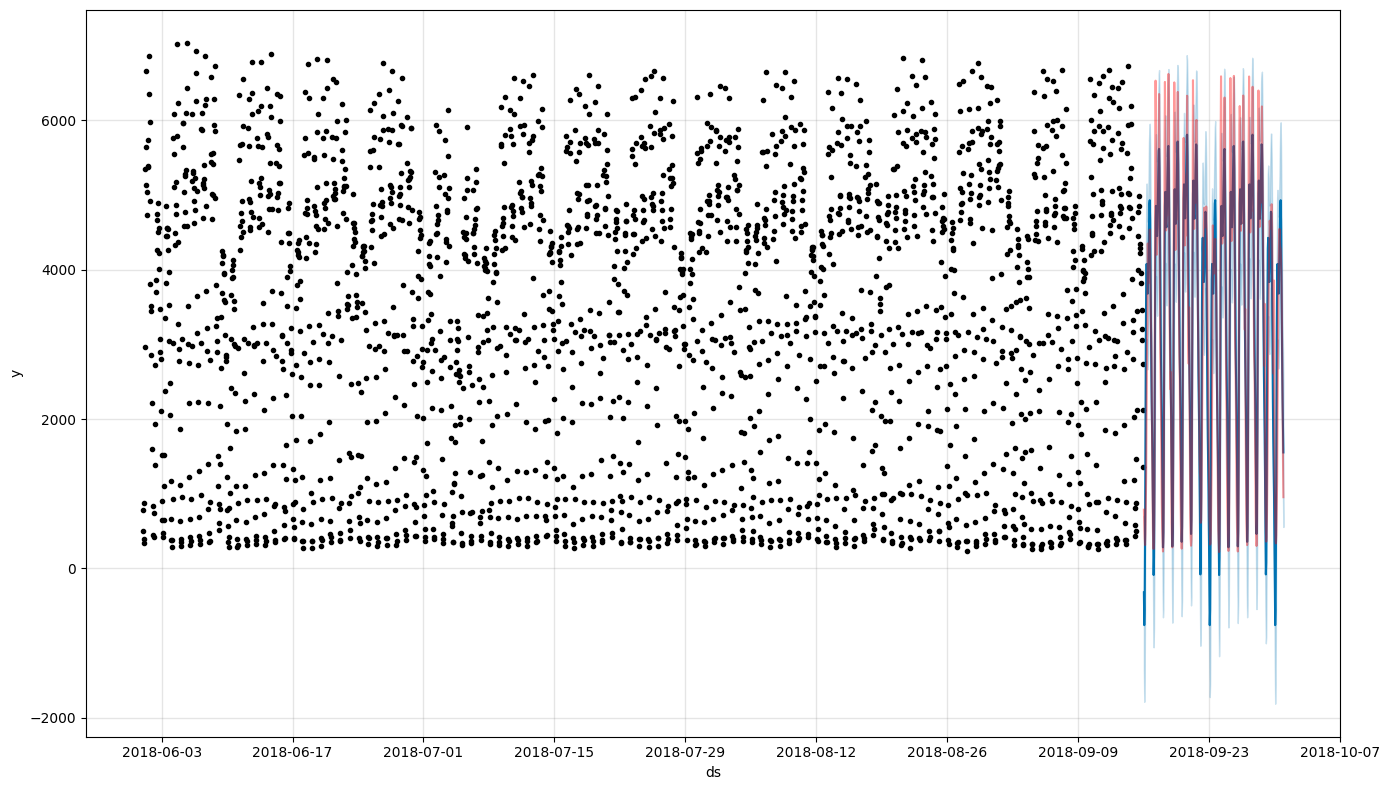

In [172]:
fig2 = fbmodel.plot(forecast, figsize=(14,8))
plt.plot(fb_y_test["ds"], fb_y_test["y"], c="r", alpha=0.4)
plt.show()

In [173]:
plot_plotly(fbmodel, forecast)

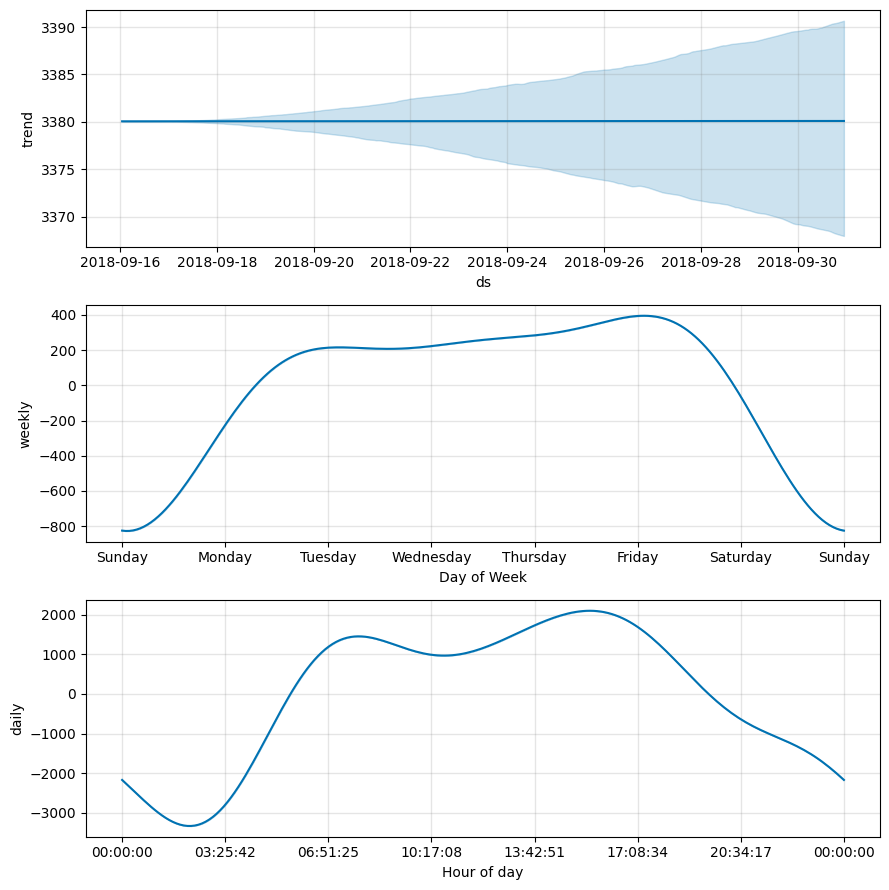

In [174]:
_ = fbmodel.plot_components(forecast)

# ARIMA

In [ ]:
!pip install pmdarima

In [176]:
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest

In [177]:
adf_test = ADFTest(alpha=0.5)
adf_test.should_diff(df.traffic_volume)

(0.01, False)

In [178]:
df_arima = pd.DataFrame()
df_arima["ds"] = pd.to_datetime(df.index)
df_arima["y"] = df['traffic_volume'].values

arima_y_train = df_arima.iloc[:-359].copy()
arima_y_test = df_arima.iloc[-359:].copy()
arima_y_val = arima_y_test[["ds"]].copy()

In [179]:
arima_y_train = arima_y_train.drop(['ds'], axis=1)
arima_y_train

,y
0,786.0
1,497.0
2,346.0
3,395.0
4,872.0
...,...
2559,3208.0
2560,3055.0
2561,2741.0
2562,2123.0


In [181]:
%%time
arima_model = auto_arima(y_train, m=12,
                        suppress_warnings=True, 
                        stepwise=True,
                        seasonal=True,
                        trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=14.65 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=46061.475, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=40831.437, Time=2.73 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=42720.503, Time=3.38 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=49623.417, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=41405.752, Time=0.13 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=26.62 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=10.05 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=41181.361, Time=1.34 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=38959.764, Time=37.25 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=38951.455, Time=31.91 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=39414.100, Time=20.98 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=42558.280, Time=25.42 sec
 ARIMA(2,0,0)(2,0,2)[12] intercept   : AIC=37996.531, Time=30.07 sec
 ARIMA(2,0,0)(1

In [182]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                 2563
Model:             SARIMAX(2, 0, 0)x(2, 0, [1, 2], 12)   Log Likelihood              -18990.265
Date:                                 Mon, 03 Apr 2023   AIC                          37996.531
Time:                                         13:06:29   BIC                          38043.322
Sample:                                              0   HQIC                         38013.497
                                                - 2563                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    484.4492     66.165      7.322      0.000     354.769     614.130
ar.L1          1.3809      0.010    134.669      0.000       1.361       1.401
ar.L2         -0.6013      0.011    -54.680      0.000      -0.623      -0.580
ar.S.L12      -0.2642      0.042     -6.264      0.000      -0.347      -0.182
ar.S.L24       0.6144      0.040     15.489      0.000       0.537       0.692
ma.S.L12       0.0868      0.050      1.741      0.082      -0.011       0.184
ma.S.L24      -0.1491      0.039     -3.851      0.000      -0.225      -0.073
sigma2      1.588e+05   2865.756     55.412      0.000    1.53e+05    1.64e+05
===================================================================================
Ljung-Box (L1) (Q):                   8.94   Jarque-Bera (JB):              1335.02
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             0.27
Prob(H) (two-sided):                  0.87   Kurtosis:                         6.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [193]:
prediction = pd.DataFrame(arima_model.predict(n_periods=359))
prediction.columns = ['predicted_traffic_volume']
prediction.head(10)

,predicted_traffic_volume
2563,1528.461604
2564,1354.727082
2565,1319.989522
2566,1229.124262
2567,1326.868529
2568,1841.207285
2569,2493.983748
2570,3051.754581
2571,3712.087455
2572,3938.650703


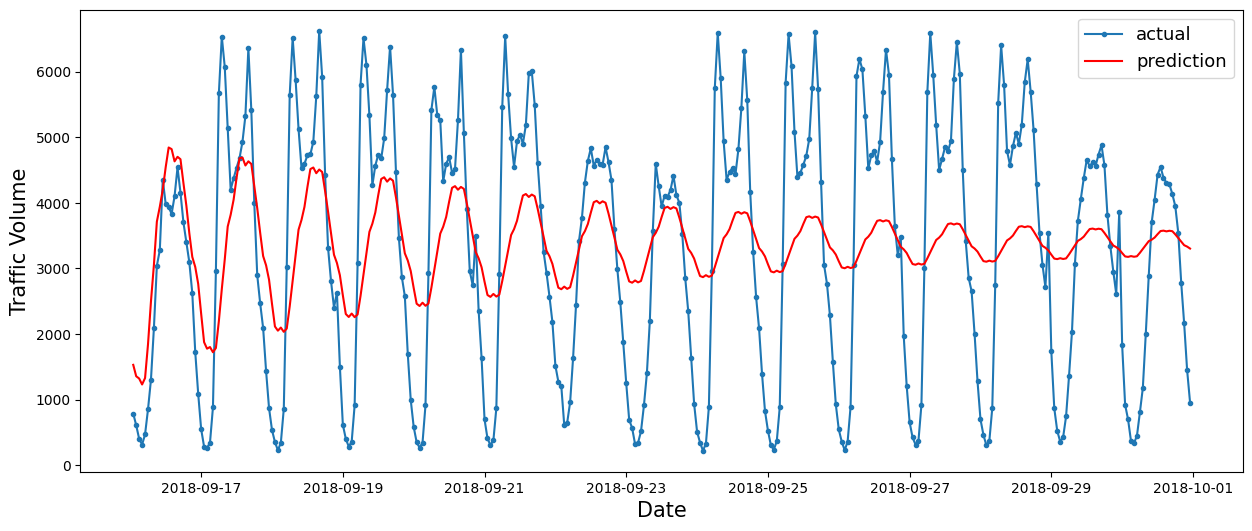

In [194]:
plot_predictions(prediction)

In [195]:
r2_score(y_test, prediction)

0.28879334272369006

In [196]:
print('Mean Absolute Error: {:.2f}'.format(mean_absolute_error(y_test, prediction)))
print('Root Mean Squared Error: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, prediction))))

Mean Absolute Error: 1377.23
Root Mean Squared Error: 1641.29
